Import relevant Python libraries.

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import product
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import csv
import seaborn as sns
import matplotlib.pyplot as plt


pd.options.mode.chained_assignment = None

# README:
 
### This notebook is divided into two parts. In part 1, we used the CLICS and the USF data to generate our own dataset for analysis ("Logistic_data.csv"). In part 2, we conducted the analysis by fitting several logistic regressions. For replication, it is sufficient to run part 2 on "Logistic_data.csv".

# Part 1: Data pre-processing

In [2]:
# df = pd.read_csv("df_all_raw.csv")
# df.columns = list(map(str.lower, df.columns))
# df = df.drop(columns=['dataset_id', 'form_id', 'form', 'gloss_in_source', 'iso639p3code', 'mrc_word', 'kucera_francis_frequency'])

/tmp/ipykernel_29/2801652837.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df_all_raw.csv")


In [3]:
# df.head()

,clics_form,concepticon_id,concepticon_gloss,ontological_category,semantic_field,variety,glottocode,macroarea,family,latitude,longitude,age_of_acquisition,concreteness,familiarity,imagability
0,san,1369,GOLD,Person/Thing,Basic actions and technology,Bugun Bichom,bich1234,NaN,Sino-Tibetan,NaN,NaN,NaN,576.0,550.0,594.0
1,san,1369,GOLD,Person/Thing,Basic actions and technology,Bugun Kaspi,kasp1234,NaN,Sino-Tibetan,NaN,NaN,NaN,576.0,550.0,594.0
2,san,1369,GOLD,Person/Thing,Basic actions and technology,Bugun Namphri,namp1239,NaN,Sino-Tibetan,NaN,NaN,NaN,576.0,550.0,594.0
3,san,1369,GOLD,Person/Thing,Basic actions and technology,Bugun Singchung,sing1271,NaN,Sino-Tibetan,NaN,NaN,NaN,576.0,550.0,594.0
4,san,1369,GOLD,Person/Thing,Basic actions and technology,Bugun Wangho,wang1301,NaN,Sino-Tibetan,NaN,NaN,NaN,576.0,550.0,594.0


## SETUP: Find common pairs of concepts in the CLICS and USF data for associativeness

In this part, we performed the following steps:

(1) Filter and extract pairs of concepts that colexified in at least in one language from the CLICS dataset;

(2) Extract cue-target pairs from the USF data along with their forward and backward strength, filtering out the ones with missing values;

(3) Find out the pairs of colexified concepts in the CLICS dataset that also exist within the USF dataset, so that we can obtain their associativeness. Here, we do not consider the order within the pairs.

In [4]:
# # Step 1: Construct a dictionary for colexified concept pairs and the counts in one language
# def per_lang_colexification_dict_only(curr_df):
#     """
#     Calculate the colexification frequency of pairs of concepts present in the current language.
#     """
#     all_combos_dict = {}
#     # We iterate through each row, which has the concepts associated with a specific word
#     for i, row in curr_df.iterrows():
#         # Get the current set of concepts
#         a = row['concepticon_gloss']
#         # Create all possible unique combinations of concepts, where each pair is alphabetically sorted
#         combos = list(set(map(lambda x: tuple(sorted(x)), product(a, a))))
#         # Ensure the concepts in the pair are not identical
#         combos = [combo for combo in combos if combo[0] != combo[1]]
#         # Add counts for a pair of combinations being colexified
#         for combo in combos:
#             if combo in all_combos_dict:
#                 all_combos_dict[combo] += 1
#             else:
#                 all_combos_dict[combo] = 1

#     return all_combos_dict

In [5]:
# # Merge across languages
# def main():
#     all_dicts = []
#     for variety in tqdm(df['variety'].unique()):
#         sub = df[df['variety'] == variety]
#         agg = sub.groupby("clics_form")[['concepticon_gloss', 'concepticon_id']].agg(list)
#         agg['num_concepts'] = agg['concepticon_gloss'].apply(lambda x: len(set(x)))
#         colex = agg[agg['num_concepts']>1]
#         colex['concepticon_gloss'] = colex['concepticon_gloss'].apply(lambda x: sorted(list(set(x))))
#         # We skip any language where no concepts are colexified
#         if colex.shape[0] == 0:
#             continue
#         curr_dict = per_lang_colexification_dict_only(colex)
#         all_dicts.append(curr_dict)
        
#     aggregated_dict = dict(sum((Counter(d) for d in all_dicts), Counter()))

#     return aggregated_dict

In [6]:
# aggregated_dict = main()

100%|██████████| 3050/3050 [05:11<00:00,  9.80it/s]


In [7]:
# # Remove parentheses and their contents inside for each concept
# # IMPORTANT: We still need to discuss further whether to consider contents in the parenteses
# cleaned_concept_dict = {(key[0].replace('(', '').replace(')', ''), key[1].replace('(', '').replace(')', '')): value for key, value in aggregated_dict.items()}
# print(len(cleaned_concept_dict))
# # print(cleaned_concept_dict)

74330


In [8]:
# cleaned_concept_set = set(cleaned_concept_dict.keys())

In [9]:
# # Step 2: Load word pairs from USF data along with their forward & backward strength
# USF_pairs_dict = dict()

# def load_USF_pairs(data_path, pairs_dict):
#     with open(data_path, 'r', newline='', encoding='utf-8') as csv_file:
#         # Create a DictReader object
#         csv_reader = csv.DictReader(csv_file)

#         # Print the header row
#         header = csv_reader.fieldnames

#         # Find all pairs in the csv
#         for row in csv_reader:
#             # Filter out the pairs with missing words & target not normed
#             if row['Target Normed?'] == 'YES' and row['Cues'] != '' and row['Targets'] != '':
#                 word_1 = row['Cues']
#                 word_2 = row['Targets']
#                 # Filter out the pairs where forward or/and backward strength are missing
#                 if row['Forward Strength'] != 'missing' and row['Backward Strength'] != 'missing':
#                     pair = (word_1, word_2)
#                     assert pair not in pairs_dict
#                     pairs_dict[pair] = [float(row['Forward Strength']), float(row['Backward Strength'])]
                    
#     return pairs_dict

            
# USF_pairs_dict = load_USF_pairs('AppendixA1.csv', USF_pairs_dict)
# USF_pairs_dict = load_USF_pairs('AppendixA2.csv', USF_pairs_dict)

# USF_pairs_set = set(USF_pairs_dict.keys())

# df_usf = pd.DataFrame.from_dict(USF_pairs_dict, orient='index', columns=['Forward_strength', 'Backward_strength'])
# # df_usf # Print out all the filtered pairs along with their forward and backward strength

In [10]:
# usf_pair_associativity = {key: sum(values) / len(values) for key, values in USF_pairs_dict.items()}

## Predictor 1: Associativity

In [11]:
# # Step 3: Find union between two sets
# common_pairs = set()
# common_pairs_associativity_dict = dict()

# for pair in cleaned_concept_set:
#     # Check if either the original pair or its reversed version is in USF_pairs_set
#     if pair in USF_pairs_set or pair[::-1] in USF_pairs_set:
#         common_pairs.add(pair)
        
#         assert pair not in common_pairs_associativity_dict
#         if pair in USF_pairs_set:
#             common_pairs_associativity_dict[pair] = sum(USF_pairs_dict[pair]) / len(USF_pairs_dict[pair])
#         elif pair[::-1] in USF_pairs_set:
#             common_pairs_associativity_dict[pair] = sum(USF_pairs_dict[pair[::-1]]) / len(USF_pairs_dict[pair[::-1]])

# print(len(common_pairs_associativity_dict))

2295


## Predictor 2: Familarity

In [12]:
# # 2. Familarity
# df_dropped_fam = df.dropna(subset=['familiarity'])
# df_familiarity = df_dropped_fam.groupby('concepticon_gloss')['familiarity'].mean().reset_index()
# # df_familiarity

# concept_fam_dict = df_familiarity.set_index('concepticon_gloss')['familiarity'].to_dict()
# # print(concept_fam_dict)

# cleaned_fam_dict = {key.replace('(', '').replace(')', ''): value for key, value in concept_fam_dict.items()}
# # print(cleaned_fam_dict)

In [13]:
# common_pair_familiarity_dict = dict()

# for pair in common_pairs:
#     concept_1 = pair[0]
#     concept_2 = pair[1]
#     if concept_1 in cleaned_fam_dict and concept_2 in cleaned_fam_dict:
#         fam_1 = cleaned_fam_dict[concept_1]
#         fam_2 = cleaned_fam_dict[concept_2]
#         avg_fam = (fam_1 + fam_2) / 2

#         assert pair not in common_pair_familiarity_dict
#         common_pair_familiarity_dict[pair] = avg_fam
    
# print(len(common_pair_familiarity_dict))

1600


# Predictor 3: Concreteness

In [14]:
# # 3. Concreteness
# df_dropped_con = df.dropna(subset=['concreteness'])
# df_concreteness = df_dropped_con.groupby('concepticon_gloss')['concreteness'].mean().reset_index()
# # cleaned_con = df_concreteness['concreteness']

# concept_concret_dict = df_concreteness.set_index('concepticon_gloss')['concreteness'].to_dict()
# cleaned_con_dict = {key.replace('(', '').replace(')', ''): value for key, value in concept_concret_dict.items()}

In [15]:
# common_pair_concreteness_dict = dict()

# for pair in common_pairs:
#     concept_1 = pair[0]
#     concept_2 = pair[1]
#     if concept_1 in cleaned_con_dict and concept_2 in cleaned_con_dict:
#         con_1 = cleaned_con_dict[concept_1]
#         con_2 = cleaned_con_dict[concept_2]
#         con_diff = abs(con_1 - con_2)

#         assert pair not in common_pair_concreteness_dict
#         common_pair_concreteness_dict[pair] = con_diff
    
# print(len(common_pair_concreteness_dict))

1460


In [18]:
# # Find union of all three dicionaries
# final_common_keys = set(common_pairs_associativity_dict.keys()) & set(common_pair_familiarity_dict.keys()) & set(common_pair_concreteness_dict.keys())
# print(len(final_common_keys)) # final number of pairs that have all data that we need!

1460


## Combine results for all three predictors

In [19]:
# # # Dictionary for associativity (1460 common pairs)
# # print(common_pairs_associativity_dict)
# associativity_pair_dict = {key: common_pairs_associativity_dict[key] for key in final_common_keys}
# print(len(associativity_pair_dict))


# # # Dictionary for familarity (1460 common pairs)
# # print(common_pairs_associativity_dict)
# familiarity_pair_dict = {key: common_pair_familiarity_dict[key] for key in final_common_keys}
# print(len(familiarity_pair_dict))


# # # Dictionary for concreteness (1460 common pairs)
# concreteness_pair_dict = {key: common_pair_concreteness_dict[key] for key in final_common_keys}
# # print(sorted(concreteness_pair_dict.keys()))

# # # Dictionary for imagability (1460 common pairs)
# # print(common_pairs_associativity_dict)
# imagability_pair_dict = {key: common_pair_imagability_dict[key] for key in final_common_keys}
# print(len(imagability_pair_dict))


1460
1460
1460


## Response variable - colex frequency

In [20]:
# import random
# # # Dictionary for colexification freq (all pairs)
# # print(cleaned_concept_dict)
# colex_freq_dict = {key: cleaned_concept_dict[key] for key in final_common_keys}
# print(len(colex_freq_dict))


# # Construct a dictionary with binary values -- if freq == 1: 0, if freq > 1: 1
# colex_pair_dict = {key: 0 if value <= 1 else 1 for key, value in colex_freq_dict.items()}

# count_1 = sum(value == 1 for value in colex_pair_dict.values())
# count_0 = sum(value == 0 for value in colex_pair_dict.values())

# print(count_1)
# print(count_0) # need to match in sample size

# # Identify pairs with value 1
# pairs_1 = [pair for pair, value in colex_pair_dict.items() if value == 1]
# print(len(pairs_1))

# random.seed(0)
# downsampled_pairs_1 = random.sample(pairs_1, count_0)
# print(len(downsampled_pairs_1))

# downsampled_dict = dict((pair, 1) for pair in downsampled_pairs_1)
# downsampled_dict.update({pair: 0 for pair, value in colex_pair_dict.items() if value == 0})
# #print(sorted(downsampled_dict.keys()))

# new_count_1 = sum(value == 1 for value in downsampled_dict.values())
# new_count_0 = sum(value == 0 for value in downsampled_dict.values())
# print(new_count_1)
# print(new_count_0)

1460
980
480
980
480
480
480


## A summary of all dictionaries

There are all 1460 concept pairs in total

## Predictor 1: associativity_pair_dict
key: concept pairs; value: associativity between two concepts

## Predictor 2: familiarity_pair_dict
key: concept pairs; value: average familiarity between two concepts

## Predictor 3: concreteness_pair_dict
key: concept pairs; value: absolute difference in concreteness between two concepts

## Response variable: colex_pair_dict
key: concept pairs; value: 1 if colexified in at least two langauges, 0 if only in one language

*note: may need to randomly downsample to match in sample size here!

## ***Update: use downsampled_dict for response variable
biased sample size may affect model predictability!

# Part 2: Main analysis

In [3]:
df = pd.read_csv("Logistic_data.csv")
response_variable = df["Colex_freq_group"].tolist()
predictors_df = df[['Associativity', 'Familiarity', 'Concreteness']]
predictors_df_associativity = df[['Associativity']]

## Fit Logistic Regression Model

In [10]:
# Check multicolinearity with VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Add a constant to the predictors_df_all DataFrame
predictors_df_constant = sm.add_constant(predictors_df)

# Calculate the VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Predictor"] = predictors_df_constant.columns
vif_data["VIF"] = [variance_inflation_factor(predictors_df_constant.values, i) for i in range(predictors_df_constant.shape[1])]

# Display the VIF data
print(vif_data)

# A VIF of close to 1 -> low multicolinearity does not indicate a problem
# concreteness and imagability obtain relatively higher VIF which is expected

       Predictor         VIF
0          const  261.923281
1  Associativity    1.017930
2    Familiarity    1.017768
3   Concreteness    1.028724


## Use 10-fold CV on single predictor: associativity

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

# Prepare X and y
pred_assoc = predictors_df['Associativity'].values.reshape(-1,1)


# Create a logistic regression model
model = LogisticRegression()

# Specify the number of folds for cross-validation (in this case, 20 folds)
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform 10-fold cross-validation and obtain predicted probabilities
predicted_probabilities_assoc = cross_val_predict(model, pred_assoc, response_variable, cv=kf, method='predict_proba')

# Extract the probability of the positive class (1)
predicted_probabilities_positive_class_assoc = predicted_probabilities_assoc[:, 1]

# Assuming you have a DataFrame with pairs and their corresponding probabilities
pairs_with_probabilities_assoc = pd.DataFrame({'Pair': df['Pair'], 'Probability': predicted_probabilities_positive_class_assoc})

# Sort the DataFrame by probabilities in descending order
pairs_with_probabilities_sorted_assoc = pairs_with_probabilities_assoc.sort_values(by='Probability', ascending=False)

# Print the sorted probabilities for each pair
print(pairs_with_probabilities_sorted_assoc)

# Perform 10-fold cross-validation and calculate accuracy scores
accuracy_scores_assoc = cross_val_score(model, pred_assoc, response_variable, cv=kf, scoring='accuracy')

# Print the accuracy scores for each fold
for fold, accuracy in enumerate(accuracy_scores_assoc, 1):
    print(f'Fold {fold}: Associativity_Accuracy = {accuracy:.4f}')

# Calculate and print the average accuracy across all folds
assoc_average_accuracy_assoc = np.mean(accuracy_scores_assoc)
print(f'Average Associativity Accuracy: {assoc_average_accuracy_assoc:.4f}')

# Find High Probability Pairs in cleaned_concept_dict to see colexification frequency count, discussed in class, 
# opposite pairs tend to be highly associated but not colexified frequently
# cleaned_concept_dict

                       Pair  Probability
728          ('DOWN', 'UP')     0.900665
96     ('FATHER', 'MOTHER')     0.880521
178       ('AUNT', 'UNCLE')     0.877067
893        ('MAN', 'WOMAN')     0.871746
476           ('HE', 'SHE')     0.863000
..                      ...          ...
234  ('MEDICINE', 'POISON')     0.446941
131         ('SALT', 'SEA')     0.446941
888        ('THINK', 'TRY')     0.446941
0          ('HOLD', 'PULL')     0.446941
538   ('JEWEL', 'NECKLACE')     0.446603

[960 rows x 2 columns]
Fold 1: Associativity_Accuracy = 0.5208
Fold 2: Associativity_Accuracy = 0.6458
Fold 3: Associativity_Accuracy = 0.5521
Fold 4: Associativity_Accuracy = 0.5938
Fold 5: Associativity_Accuracy = 0.4688
Fold 6: Associativity_Accuracy = 0.5938
Fold 7: Associativity_Accuracy = 0.6354
Fold 8: Associativity_Accuracy = 0.6667
Fold 9: Associativity_Accuracy = 0.6146
Fold 10: Associativity_Accuracy = 0.5729
Average Associativity Accuracy: 0.5865


## Use 10-fold CV on single predictor: Familarity

In [12]:
# Prepare X and y
pred_fam = predictors_df['Familiarity'].values.reshape(-1,1)


# Create a logistic regression model
model = LogisticRegression()

# Specify the number of folds for cross-validation (in this case, 20 folds)
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform 10-fold cross-validation and obtain predicted probabilities
predicted_probabilities_fam = cross_val_predict(model, pred_fam, response_variable, cv=kf, method='predict_proba')
# print(predicted_probabilities)

# Extract the probability of the positive class (1)
predicted_probabilities_positive_class_fam = predicted_probabilities_fam[:, 1]
print(len(predicted_probabilities_positive_class_fam))


# Assuming you have a DataFrame with pairs and their corresponding probabilities
pairs_with_probabilities_fam = pd.DataFrame({'Pair': df['Pair'], 'Probability': predicted_probabilities_positive_class_fam})

# Sort the DataFrame by probabilities in descending order
pairs_with_probabilities_sorted_fam = pairs_with_probabilities_fam.sort_values(by='Probability', ascending=False)

# Print the sorted probabilities for each pair
print(pairs_with_probabilities_sorted_fam)

# Perform 10-fold cross-validation and calculate accuracy scores
accuracy_scores_fam = cross_val_score(model, pred_fam, response_variable, cv=kf, scoring='accuracy')

# Print the accuracy scores for each fold
for fold, accuracy in enumerate(accuracy_scores_fam, 1):
    print(f'Fold {fold}: Familiarity_Accuracy = {accuracy:.4f}')

# Calculate and print the average accuracy across all folds
fam_average_accuracy = np.mean(accuracy_scores_fam)
print(f'Average Familiarity Accuracy: {fam_average_accuracy:.4f}')

960
                          Pair  Probability
467       ('AFTERNOON', 'SUN')     0.519196
196     ('NEWSPAPER', 'PAPER')     0.517034
25          ('DRINK', 'WATER')     0.515952
331         ('SUN', 'WEATHER')     0.514252
556        ('CLOTHES', 'WASH')     0.513210
..                         ...          ...
299         ('BUNCH', 'CROWD')     0.478382
481        ('FISH', 'LOBSTER')     0.477455
328   ('LIGHTNING', 'THUNDER')     0.476220
309  ('CATERPILLAR', 'INSECT')     0.474214
377         ('BEGGAR', 'POOR')     0.471747

[960 rows x 2 columns]
Fold 1: Familiarity_Accuracy = 0.4583
Fold 2: Familiarity_Accuracy = 0.4375
Fold 3: Familiarity_Accuracy = 0.4375
Fold 4: Familiarity_Accuracy = 0.3854
Fold 5: Familiarity_Accuracy = 0.4375
Fold 6: Familiarity_Accuracy = 0.4688
Fold 7: Familiarity_Accuracy = 0.4479
Fold 8: Familiarity_Accuracy = 0.3958
Fold 9: Familiarity_Accuracy = 0.4375
Fold 10: Familiarity_Accuracy = 0.4375
Average Familiarity Accuracy: 0.4344


## Use 10-fold CV on single predictor: Concretness

In [23]:
# Prepare X and y
pred_con = predictors_df['Concreteness'].values.reshape(-1,1)

# Create a logistic regression model
model = LogisticRegression()

# Specify the number of folds for cross-validation (in this case, 20 folds)
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform 10-fold cross-validation and obtain predicted probabilities
predicted_probabilities_con = cross_val_predict(model, pred_con, response_variable, cv=kf, method='predict_proba')

# Extract the probability of the positive class (1)
predicted_probabilities_positive_class_con = predicted_probabilities_con[:, 1]

# Assuming you have a DataFrame with pairs and their corresponding probabilities
pairs_with_probabilities_con = pd.DataFrame({'Pair': df['Pair'], 'Probability': predicted_probabilities_positive_class_con, 'Concrete': df['Concreteness']})

# Sort the DataFrame by probabilities in descending order
pairs_with_probabilities_sorted_con = pairs_with_probabilities_con.sort_values(by='Probability', ascending=False)

# Print the sorted probabilities for each pair
print(pairs_with_probabilities_sorted_con)

# Perform 10-fold cross-validation and calculate accuracy scores
accuracy_scores_con = cross_val_score(model, pred_con, response_variable, cv=kf, scoring='accuracy')

# Print the accuracy scores for each fold
for fold, accuracy in enumerate(accuracy_scores_con, 1):
    print(f'Fold {fold}: Concreteness_Accuracy = {accuracy:.4f}')

# Calculate and print the average accuracy across all folds
con_average_accuracy = np.mean(accuracy_scores_con)
print(f'Average Concretness Accuracy: {con_average_accuracy:.4f}')

                    Pair  Probability  Concrete
574  ('CHEESE', 'MOUSE')     0.577042       0.0
156    ('BITE', 'STING')     0.577042       0.0
27    ('COTTON', 'WOOL')     0.577042       0.0
607  ('MURDER', 'SHOOT')     0.575033       0.0
816     ('MELT', 'SOFT')     0.574055       1.0
..                   ...          ...       ...
847   ('BLOOD', 'FIRST')     0.279775     302.0
692    ('FLOW', 'WATER')     0.277429     305.0
384    ('HEART', 'SOUL')     0.276321     316.0
505     ('BE', 'FLOWER')     0.243249     359.0
448     ('BRAVE', 'MAN')     0.237781     335.0

[960 rows x 3 columns]
Fold 1: Concreteness_Accuracy = 0.4792
Fold 2: Concreteness_Accuracy = 0.5104
Fold 3: Concreteness_Accuracy = 0.5521
Fold 4: Concreteness_Accuracy = 0.6771
Fold 5: Concreteness_Accuracy = 0.5208
Fold 6: Concreteness_Accuracy = 0.5000
Fold 7: Concreteness_Accuracy = 0.5729
Fold 8: Concreteness_Accuracy = 0.5208
Fold 9: Concreteness_Accuracy = 0.4479
Fold 10: Concreteness_Accuracy = 0.5000
Average C

## Concept pair analysis

In [14]:
# Assuming you have a DataFrame with pairs and their corresponding probabilities for both predictors
merged_probabilities = pd.DataFrame({
    'Pair': df['Pair'],
    'Probability_Associativity': predicted_probabilities_positive_class_assoc,
    'Probability_Concreteness': predicted_probabilities_positive_class_con
})

# Sort the DataFrame by probabilities in descending order for both predictors
merged_probabilities_sorted_assoc = merged_probabilities.sort_values(by='Probability_Associativity', ascending=False)
merged_probabilities_sorted_con = merged_probabilities.sort_values(by='Probability_Concreteness', ascending=False)

# Add a new column 'Rank' based on the 'Probability_Associativity' in 'Concreteness'
merged_probabilities_sorted_con['Rank_Associativity'] = merged_probabilities_sorted_con['Probability_Associativity'].rank(ascending=False)

# Add a new column 'Rank' based on the 'Probability_Concreteness' in 'Associativity'
merged_probabilities_sorted_assoc['Rank_Concreteness'] = merged_probabilities_sorted_assoc['Probability_Concreteness'].rank(ascending=False)

# Print the ranking and probability of top pairs for both scenarios
print("\nRanking and Probability of Top Concreteness Pairs in Associativity:")
print(merged_probabilities_sorted_con[['Pair', 'Rank_Associativity', 'Probability_Associativity', 'Probability_Concreteness']].head())

print("\nRanking and Probability of Top Associativity Pairs in Concreteness:")
print(merged_probabilities_sorted_assoc[['Pair', 'Rank_Concreteness', 'Probability_Concreteness', 'Probability_Associativity']].head())


Ranking and Probability of Top Concreteness Pairs in Associativity:
                    Pair  Rank_Associativity  Probability_Associativity  \
574  ('CHEESE', 'MOUSE')               137.0                   0.546061   
156    ('BITE', 'STING')               440.0                   0.475786   
27    ('COTTON', 'WOOL')               273.5                   0.496825   
607  ('MURDER', 'SHOOT')               496.0                   0.472915   
816     ('MELT', 'SOFT')               426.5                   0.476681   

     Probability_Concreteness  
574                  0.577042  
156                  0.577042  
27                   0.577042  
607                  0.575033  
816                  0.574055  

Ranking and Probability of Top Associativity Pairs in Concreteness:
                     Pair  Rank_Concreteness  Probability_Concreteness  \
728        ('DOWN', 'UP')              584.0                  0.507428   
96   ('FATHER', 'MOTHER')              126.5                  0.557314 

In [15]:
# Create a logistic regression model
model_all = LogisticRegression()

# Removed the irrelevant predictor "Familiarity" increased multiple logistic regression accuracy
predictors_df_2 = df[['Associativity', 'Concreteness']]

predictors_df_3 = df[['Associativity', 'Familiarity', 'Concreteness']]
# Specify the number of folds for cross-validation (in this case, 20 folds)
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform 10-fold cross-validation and calculate accuracy scores
accuracy_scores_all = cross_val_score(model_all, predictors_df_2, response_variable, cv=kf, scoring='accuracy')

# Print the accuracy scores for each fold
for fold, accuracy in enumerate(accuracy_scores_all, 1):
    print(f'Fold {fold}: All_Predictors_Accuracy = {accuracy:.4f}')

# Calculate and print the average accuracy across all folds
avg_accuracy_all = np.mean(accuracy_scores_all)
print(f'Average All Predictors Accuracy: {avg_accuracy_all:.4f}')

Fold 1: All_Predictors_Accuracy = 0.5521
Fold 2: All_Predictors_Accuracy = 0.5938
Fold 3: All_Predictors_Accuracy = 0.6042
Fold 4: All_Predictors_Accuracy = 0.6250
Fold 5: All_Predictors_Accuracy = 0.5521
Fold 6: All_Predictors_Accuracy = 0.5521
Fold 7: All_Predictors_Accuracy = 0.5729
Fold 8: All_Predictors_Accuracy = 0.5938
Fold 9: All_Predictors_Accuracy = 0.5312
Fold 10: All_Predictors_Accuracy = 0.5729
Average All Predictors Accuracy: 0.5750


In [16]:
# Create a logistic regression model
model_all = LogisticRegression()

predictors_df_3 = df[['Associativity', 'Familiarity', 'Concreteness']]
# Specify the number of folds for cross-validation (in this case, 20 folds)
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform 10-fold cross-validation and calculate accuracy scores
accuracy_scores_all_3 = cross_val_score(model_all, predictors_df_3, response_variable, cv=kf, scoring='accuracy')

# Print the accuracy scores for each fold
for fold, accuracy in enumerate(accuracy_scores_all_3, 1):
    print(f'Fold {fold}: All_Predictors_Accuracy = {accuracy:.4f}')

# Calculate and print the average accuracy across all folds
avg_accuracy_all_3 = np.mean(accuracy_scores_all_3)
print(f'Average All Predictors Accuracy: {avg_accuracy_all_3:.4f}')

Fold 1: All_Predictors_Accuracy = 0.5625
Fold 2: All_Predictors_Accuracy = 0.5833
Fold 3: All_Predictors_Accuracy = 0.6042
Fold 4: All_Predictors_Accuracy = 0.6146
Fold 5: All_Predictors_Accuracy = 0.5417
Fold 6: All_Predictors_Accuracy = 0.5625
Fold 7: All_Predictors_Accuracy = 0.5938
Fold 8: All_Predictors_Accuracy = 0.5833
Fold 9: All_Predictors_Accuracy = 0.5417
Fold 10: All_Predictors_Accuracy = 0.5729
Average All Predictors Accuracy: 0.5760


Coefficients for each predictor:
Associativity: 2.7283700377331725
Familiarity: 0.0002736369783511713
Concreteness: -0.003629453118806178


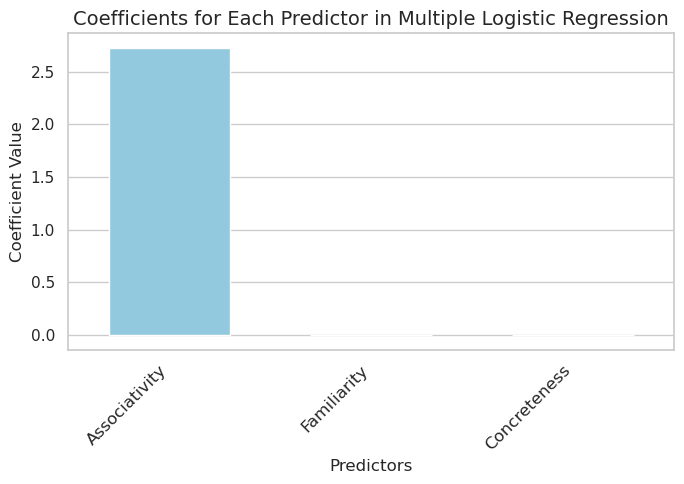

In [29]:
# Fit the model on the entire dataset
model_all.fit(predictors_df_3, response_variable)

# Get the coefficients
coefficients_all = model_all.coef_

# Display the coefficients
print("Coefficients for each predictor:")
for predictor, coef in zip(predictors_df_3.columns, coefficients_all[0]):
    print(f"{predictor}: {coef}")
    
# Get the coefficients
coefficients_all = model_all.coef_

# List of coefficients and corresponding predictor names
coefficients_values = coefficients_all.flatten()
predictor_names = predictors_df_3.columns

# Set seaborn style (optional, choose the one you prefer)
sns.set(style="whitegrid")

# Create a barplot for coefficients using seaborn
plt.figure(figsize=(7, 5))
sns.barplot(x=predictor_names, y=coefficients_values, color='skyblue', width=0.6)

# Add labels and title
plt.xlabel('Predictors', fontsize=12)
plt.ylabel('Coefficient Value', fontsize=12)
plt.title('Coefficients for Each Predictor in Multiple Logistic Regression', fontsize=14)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha="right", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

## Bootstrap for coefficient significance¶

In [25]:
# Apply bootstrap to each row of the DataFrame
import random
random.seed(0)

predictor_columns = ['Associativity', 'Familiarity', 'Concreteness']

num_sim = 10000
assoc_coeff = list()
con_coeff = list()
fam_coeff = list()

for i in tqdm(range(10000)):
    bootstrap_samples = df.sample(n=len(df), replace=True)
    # bootstrap_samples['Colex_freq_group'].value_counts()

    model_all = LogisticRegression()
    boot_response_variable = bootstrap_samples['Colex_freq_group']
    boot_predictors_df = bootstrap_samples[predictor_columns]

    model_all.fit(boot_predictors_df, boot_response_variable)

    # Get the coefficients
    coefficients_all = model_all.coef_
    
    assoc_coeff.append(coefficients_all[0][0])
    fam_coeff.append(coefficients_all[0][1])
    con_coeff.append(coefficients_all[0][2])

100%|██████████| 10000/10000 [01:18<00:00, 127.15it/s]

10000
10000
10000


In [26]:
confint_assoc = np.percentile(assoc_coeff, [2.5, 97.5])
confint_assoc 

array([1.65607378, 3.77681142])

In [27]:
confint_con = np.percentile(con_coeff, [2.5, 97.5])
confint_con

array([-0.00570722, -0.00171718])

In [28]:
confint_fam = np.percentile(fam_coeff, [2.5, 97.5])
confint_fam

array([-0.00177756,  0.00361861])

In [20]:
# Fit the model on the entire dataset
model_all.fit(predictors_df_associativity, response_variable)

# Get the coefficients
coefficients_all = model_all.coef_

# Display the coefficients
print("Coefficients for each predictor:")
for predictor, coef in zip(predictors_df_associativity.columns, coefficients_all[0]):
    print(f"{predictor}: {coef}")

Coefficients for each predictor:
Associativity: 2.8814284343178853


## Barplot to visualize predictive accuracy

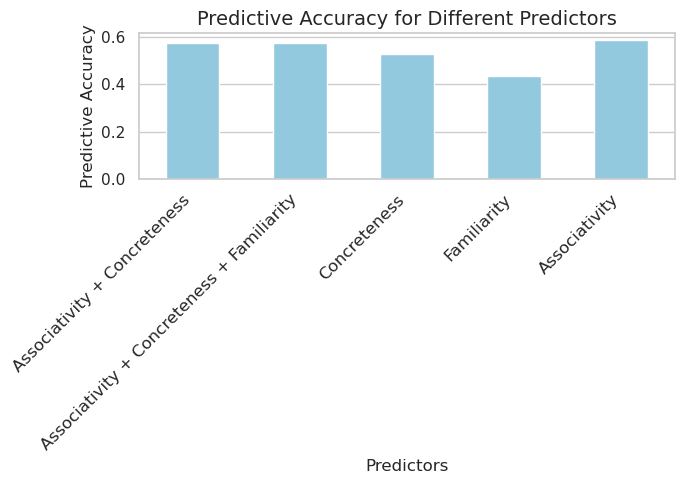

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of accuracy values
accuracy_values = [avg_accuracy_all, avg_accuracy_all_3, con_average_accuracy, fam_average_accuracy, assoc_average_accuracy_assoc]

# List of corresponding predictor names
predictor_names = ['Associativity + Concreteness', "Associativity + Concreteness + Familiarity", 'Concreteness', 'Familiarity', 'Associativity']

# Set seaborn style (optional, choose the one you prefer)
sns.set(style="whitegrid")

# Create a barplot using seaborn
plt.figure(figsize=(7, 5))
sns.barplot(x=predictor_names, y=accuracy_values, color='skyblue', width=0.5)

# Add labels and title
plt.xlabel('Predictors', fontsize=12)
plt.ylabel('Predictive Accuracy', fontsize=12)
plt.title('Predictive Accuracy for Different Predictors', fontsize=14)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha="right", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()